In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run init.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting up variables & DB connection for experiment:

*******************
25similar
*******************
Created snorkel session from  postgres:///snorkel25similar


In [12]:
pkl_paths

'pickles/25similar/'

In [13]:
path_candidate_dict_pkl

'pickles/25similar/candidate_dict.pickle'

In [14]:
# Rebuild text
from sklearn_bridge import recreate_text_representation, candidate_dict_to_df
import sklearn, pickle, time, seaborn
import pandas as pd
from itertools import product

In [15]:
from MLutils import report_to_df, train_evaluate, diversity_heatmap

In [17]:
with open(path_candidate_dict_pkl, 'rb') as f:
    candidate_dict = pickle.load(f)

for splt in candidate_dict.keys():
    print "Split = %i : imported %i candidates" %(splt, len(candidate_dict[splt].keys()))

Split = 0 : imported 13007 candidates
Split = 1 : imported 3242 candidates
Split = 2 : imported 8221 candidates
Split = 3 : imported 130424 candidates


In [5]:
# Decide on text representation
trim_text = True
trim_window = 5
use_lemmas = True

df_train = candidate_dict_to_df(candidate_dict[0],trim_text=trim_text, window=trim_window, lemmas = use_lemmas )
df_val = candidate_dict_to_df(candidate_dict[1],trim_text=trim_text, window=trim_window, lemmas = use_lemmas )
df_test = candidate_dict_to_df(candidate_dict[2],trim_text=trim_text, window=trim_window, lemmas = use_lemmas )

df_unlab = candidate_dict_to_df(candidate_dict[3],trim_text=trim_text, window=trim_window, lemmas = use_lemmas )


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


In [7]:
text_vectorizer = TfidfVectorizer(ngram_range=[0,3])
# svd = TruncatedSVD(n_components=200)


In [8]:
X_train = text_vectorizer.fit_transform(df_train.text)
y_train = df_train.label

X_val = text_vectorizer.transform(df_val.text)
y_val = df_val.label

X_test = text_vectorizer.transform(df_test.text)
y_test = df_test.label


# X_unlab = text_vectorizer.transform(df_unlab_sim.text)
# # X_unlab = svd.transform(X_unlab)



# Boosting

## AdaBoost

In [9]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import shuffle

In [12]:
# indices = np.arange(y_train.shape[0])
# np.random.shuffle(indices)
# X_train, y_train =  X_train[indices], y_train[indices]

In [13]:
X_train,y_train = shuffle(X_train,y_train, random_state=0)

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
from sklearn.metrics import f1_score, mean_squared_error

** Decision Trees **

In [14]:
# estimators = range(50,351,150)
estimators = [1,5,25]+range(50,701,50)

f1_scores_df = pd.DataFrame(index=estimators)
mse_scores_df = pd.DataFrame(index=estimators)


for n in estimators:
    clf = AdaBoostClassifier(n_estimators=n )
    clf.fit(X_train,y_train)
    
    pred = clf.predict(X_train)
    f1_scores_df.loc[n,'f1_train'] = f1_score(y_train,pred)
    mse_scores_df.loc[n,'MSE_train'] = mean_squared_error(y_train,pred)
    
    
    pred = clf.predict(X_val)
    f1_scores_df.loc[n,'f1_val'] = f1_score(y_val,pred)
    mse_scores_df.loc[n,'MSE_val'] = mean_squared_error(y_val,pred)
    
#     scores_df['train_score'] = clf.score(X_train,y_train)



# scores = validation_curve(clf, X_train, y_train,
#                          'n_estimators', estimators)


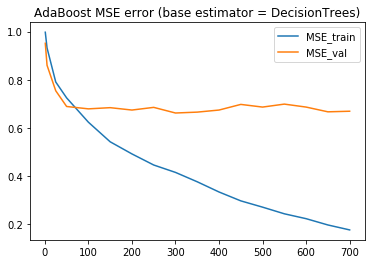

In [15]:
# that was without probabilities
mse_scores_df.plot(title='AdaBoost MSE error (base estimator = DecisionTrees)')

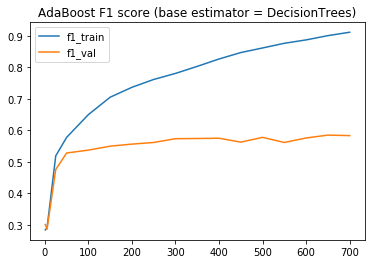

In [16]:
# that was without probabilities
f1_scores_df.plot(title='AdaBoost F1 score (base estimator = DecisionTrees)')

In [17]:
f1_scores_df

,f1_train,f1_val
1,0.283948,0.300997
5,0.290662,0.286592
25,0.518727,0.475536
50,0.577427,0.527919
100,0.649723,0.537037
150,0.704877,0.549593
200,0.736251,0.556098
250,0.761182,0.561265
300,0.780297,0.573248
350,0.802653,0.573913


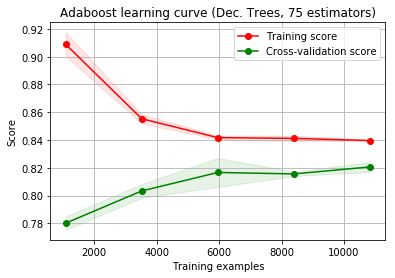

In [61]:
plot_learning_curve(train_scores, 
                        valid_scores,
                        train_sizes=train_sizes,
                   title = 'Adaboost learning curve (Dec. Trees, 75 estimators)')

plt.show()

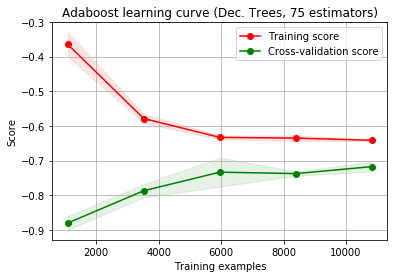

In [70]:
plot_learning_curve(train_scores, 
                        valid_scores,
                        train_sizes=train_sizes,
                   title = 'Adaboost learning curve (Dec. Trees, 75 estimators)')

plt.show()

In [71]:
## F1 score

In [72]:
train_sizes, train_scores, valid_scores = learning_curve(
    AdaBoostClassifier(n_estimators=75 ),
    X_all, y_all, 
    #train_sizes=range(1000, X_train.shape[0], 1000), 
    groups = X_all_split,
    scoring = f1_scorer
)


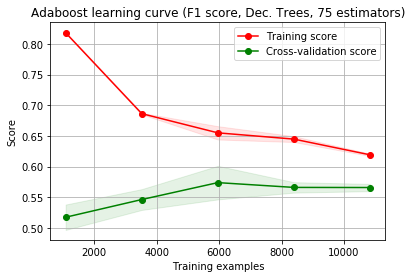

In [74]:
plot_learning_curve(train_scores, 
                        valid_scores,
                        train_sizes=train_sizes,
                   title = 'Adaboost learning curve (F1 score, Dec. Trees, 75 estimators)')

plt.show()

** With Linear SVC **

In [88]:
from sklearn.svm import SVC

In [75]:
# estimators = range(50,351,150)
estimators = [1,5,25] #+range(50,351,25)

scores_df = pd.DataFrame(index=estimators)



for n in estimators:
    clf = AdaBoostClassifier(n_estimators=n, 
                             base_estimator = LinearSVC,
                             algorithm='SAMME'
                            )
    clf.fit(X_train,y_train)
    
    pred = clf.predict(X_train)
    scores_df.loc[n,'f1_train'] = f1_score(y_train,pred)
    pred = clf.predict(X_val)
    scores_df.loc[n,'f1_val'] = f1_score(y_val,pred)
#     scores_df['train_score'] = clf.score(X_train,y_train)



# scores = validation_curve(clf, X_train, y_train,
#                          'n_estimators', estimators)


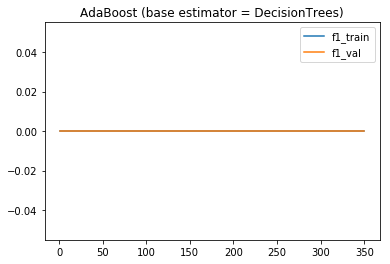

In [83]:
scores_df.plot(title='AdaBoost (base estimator = LR)')

## BrownBoost

In [79]:
from MLutils import BrownBoost

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
# prediction = brownboost.predict(X_test)
# accuracy = accuracy_score(y_test, prediction)
# precision = precision_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# recall = recall_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# clf_f1_score = f1_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# print("mean accuracy : %.4f \n" % accuracy)
# precision, recall, clf_f1_score

In [110]:
base_estimator = DecisionTreeClassifier(max_depth=1)
brownboost = BrownBoost(base_estimator, c=1)
st_time = time.time()

brownboost.fit(X_train, np.array(y_train))
pred = brownboost.predict(X_train)
f1_train = f1_score(y_train,pred)
pred = brownboost.predict(X_val)
f1_val = f1_score(y_val,pred)
print f1_train,f1_val
print time.time()-st_time

0.724848915748 0.573268921095
808.138631821


In [76]:
## BrownBoost learning curves

In [77]:
import time

In [93]:
from MLutils import BrownBoost

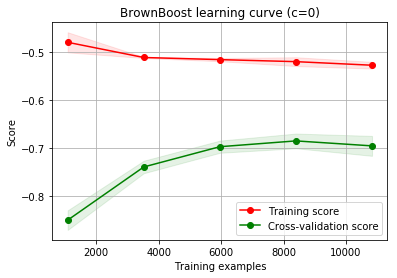

5793.73460007


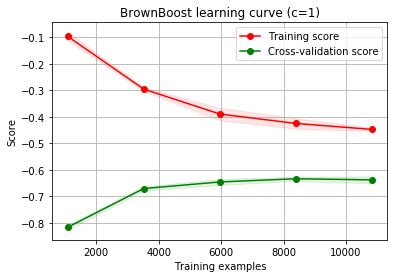

8870.76387811


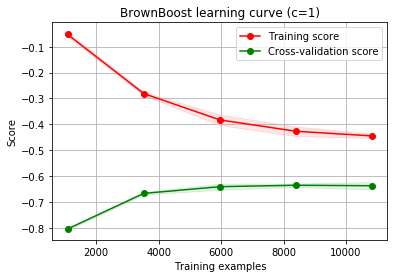

8856.51826715


In [113]:
#define BrownBoost hyperparams

for c in [.5,1,1.5]:

    base_estimator = DecisionTreeClassifier(max_depth=1)

    st_time = time.time()
    train_sizes, train_scores, valid_scores = learning_curve(
        BrownBoost(base_estimator, c=c) ,
        X_all, y_all, 
        #train_sizes=range(1000, X_train.shape[0], 1000), 
        groups = X_all_split,
        scoring = mse_scorer,
        n_jobs = -1

    )

    plot_learning_curve(train_scores, 
                            valid_scores,
                            train_sizes=train_sizes,
                       title = 'BrownBoost learning curve (c=%.2f)'%c)

    plt.show()
    print time.time()-st_time

## RobustBoost

In [113]:
from MLutils import RobustBoost

In [114]:
from sklearn.tree import DecisionTreeClassifier

In [117]:
base_estimator = DecisionTreeClassifier(max_depth=1)
robustboost = RobustBoost(base_estimator)

In [118]:
# prediction = brownboost.predict(X_test)
# accuracy = accuracy_score(y_test, prediction)
# precision = precision_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# recall = recall_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# clf_f1_score = f1_score(y_test, prediction, pos_label=1, labels=[-1, 1])
# print("mean accuracy : %.4f \n" % accuracy)
# precision, recall, clf_f1_score

In [119]:
# robustboost.fit(X_train, np.array(y_train))
# pred = robustboost.predict(X_train)
# f1_train = f1_score(y_train,pred)
# pred = robustboost.predict(X_val)
# f1_val = f1_score(y_val,pred)
# print f1_train,f1_val

NameError: global name 't' is not defined